In [40]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer, LabelEncoder, MaxAbsScaler, MinMaxScaler, OneHotEncoder, \
    OrdinalEncoder, RobustScaler, StandardScaler

# Exercise 2 - Debugging - Drugs

The dataset contains a set of patients, all of whom suffered from the same illness.
During their course of treatment, each patient responded to one of 5 medications: Drug A, Drug B, Drug c, Drug x or y.

This complex dataset proposes a set of challenges that you'll try to overcome. A basic ML pipeline is already in place. You have to optimize the performance of the model by applying good practices, debugging pre-processing errors, etc.

**Rules**:
- Do not use other modules than those already imported *(or do it only if your own code is not working. In this case, keep your own code in the notebook, commented, so that we know what you tried)*.
- Explain **all** of your choices. For every task, choose the most appropriate option for this problem and describe your choice.
- You can modify any parts of the code or replace the model by one already used in previous PWs.

**Work to do**:
- [ ] Apply a type of normalization.
- [ ] Encode categorical data.
- [ ] Use all columns in the dataset (or choose the most meaningful features).
- [ ] Choose a more appropriate metric.
- [ ] Optimize hyper-parameters.
- [ ] Test the model performance correctly using a separated test set.
- Apply **two** of those techniques:
  - [ ] Keep relative class frequencies in the train/test sets (check train_test_split docs)
  - [ ] Show which feature(s) are the most correlated to the target.
  - [ ] Use cross-validation.

In [41]:
df = pd.read_csv("drug.csv")
df.head()

,age,sex,bp,cholesterol,Na_to_K,drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          200 non-null    int64  
 1   sex          200 non-null    object 
 2   bp           200 non-null    object 
 3   cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [43]:
sex_map = {'F': 0, 'M': 1}

# regex - preprocessing data
df['sex'] = df['sex'].astype(str)
df['sex'] = df['sex'].str.strip()  
df['sex'] = df['sex'].str.upper()    
sex_map = {'F': 0, 'M': 1}
df['sex'] = df['sex'].map(sex_map)
df['sex'] = df['sex'].astype('int8')

ohe_base_cols = ['bp', 'cholesterol']
ohe_cols = [c for c in ohe_base_cols if c in df.columns]


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded = ohe.fit_transform(df[ohe_cols])
encoded_cols = ohe.get_feature_names_out(ohe_cols)
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)


df = pd.concat([df.drop(columns=ohe_cols, errors='ignore'), encoded_df], axis=1)
df[encoded_cols] = df[encoded_cols].astype('int8')


le_drug = LabelEncoder()
df['drug'] = pd.Series(le_drug.fit_transform(df['drug']), index=df.index).astype('int16')

In [44]:
X = df.drop(columns="drug")
X = df.drop(columns="age")
X = df.drop(columns="sex")
y = df["drug"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# TODO: preprocessing / encoding / normalization are likely missing here...
scaler = MinMaxScaler() 

X_train_scaled = scaler.fit_transform(X_train) # normalisation entraînement et test
X_test_scaled = scaler.transform(X_test)

In [47]:
knn = KNeighborsClassifier(4)  # you may change the classifier if you want, or tune its hyperparameters
knn.fit(X_train, y_train)

,n_neighbors,4
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [48]:
def predict(estimator, X, y):
    # predict
    y_pred = knn.predict(X)
    
    # show confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
    disp.plot()
    
    # check metric (this one is probably not the best choice...)
    metric = metrics.accuracy_score(y, y_pred)
    print(f"Accuracy: {metric}")

Accuracy: 0.825


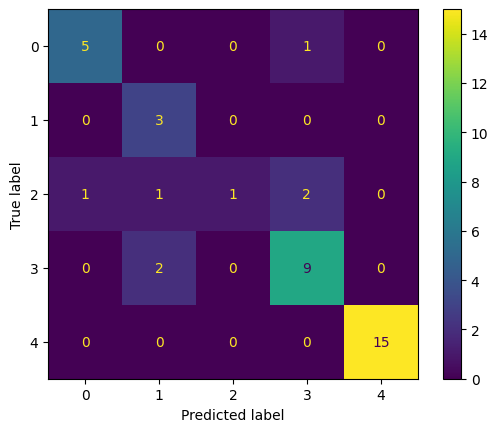

In [49]:
predict(knn, X_test, y_test) # test set

Accuracy: 0.90625


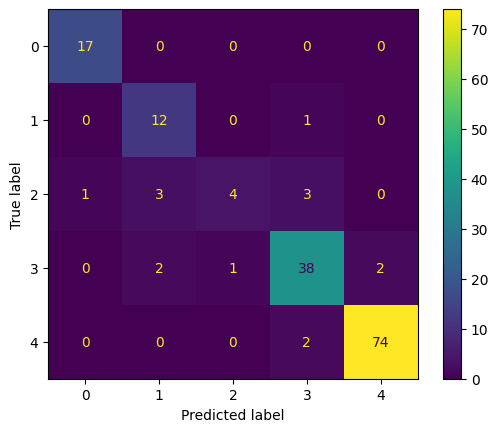

In [50]:
predict(knn, X_train, y_train) # training set

In [ ]:



# pour cross-validation,garde la même proportion de classes dans chaque fold
# évite d’avoir un fold sans certaines classes.
from sklearn.model_selection import StratifiedKFold
# permet d'évaluer le modèle mieux que juste accuracy
from sklearn.metrics import balanced_accuracy_score

print("Features correlation avec cible")

#encode cible pour calculer la corrélation
le = LabelEncoder()
df['drug_num'] = le.fit_transform(df['drug'])
target_col = 'drug_num'

# calcule la corrélation
corr_matrix = df.select_dtypes(include=[np.number]).corr(numeric_only=True)

# Tri
corr_target = corr_matrix[target_col].sort_values(ascending=False)
print(corr_target.to_string())

print("")
print("Cross-validation (balanced accuracy)")

# 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scores = []
fold_num = 1

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    # découpage
    X_tr = X_train_scaled[train_idx]
    X_va = X_train_scaled[val_idx]
    y_tr = y_train.iloc[train_idx]
    y_va = y_train.iloc[val_idx]

    # entrainement
    knn.fit(X_tr, y_tr)

    # prédiction
    y_pred = knn.predict(X_va)

    # Calcule balanced accuracy
    score = balanced_accuracy_score(y_va, y_pred)
    scores.append(score)

    print(f"Fold {fold_num} -> score: {score}")
    fold_num += 1

# Moyenne finale
mean_score = float(np.mean(scores))
print("\nScores des folds:", scores)
print("Score moyen:", mean_score)

Features correlation avec cible
drug                  1.000000
drug_num              1.000000
Na_to_K               0.589120
bp_NORMAL             0.245696
bp_LOW                0.174805
cholesterol_NORMAL    0.055629
age                  -0.004828
cholesterol_HIGH     -0.055629
sex                  -0.098573
bp_HIGH              -0.397846

Cross-validation (balanced accuracy)
Fold 1 -> score: 0.9733333333333334
Fold 2 -> score: 1.0
Fold 3 -> score: 1.0
Fold 4 -> score: 0.975
Fold 5 -> score: 0.9866666666666667

Scores des folds: [0.9733333333333334, 1.0, 1.0, 0.975, 0.9866666666666667]
Score moyen: 0.9870000000000001
